In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm

In [2]:
tickers=['AAPL','AMZN','TSLA','GOOGL','MSFT']
weights=np.array([0.20,0.20,0.20,0.20,0.20])
for t in tickers:
    data=yf.download(tickers,start="2022-1-1",end="2025-1-1",auto_adjust=False)['Adj Close']

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


In [3]:
data.tail()

Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2024-12-24,257.037476,229.050003,195.344940,436.112854,462.279999
2024-12-26,257.853790,227.050003,194.836945,434.901825,454.130005
2024-12-27,254.439224,223.750000,192.007996,427.377319,431.660004
2024-12-30,251.064499,221.300003,190.493958,421.719055,417.410004
2024-12-31,249.292511,219.389999,188.561523,418.413452,403.839996


In [4]:
returns=data.pct_change().dropna()
returns

Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2022-01-04,-0.012691,-0.016916,-0.004083,-0.017147,-0.041833
2022-01-05,-0.026600,-0.018893,-0.045876,-0.038388,-0.053471
2022-01-06,-0.016694,-0.006711,-0.000200,-0.007902,-0.021523
2022-01-07,0.000989,-0.004288,-0.005303,0.000510,-0.035447
2022-01-10,0.000116,-0.006570,0.012061,0.000732,0.030342
...,...,...,...,...,...
2024-12-24,0.011478,0.017729,0.007604,0.009374,0.073572
2024-12-26,0.003176,-0.008732,-0.002601,-0.002777,-0.017630
2024-12-27,-0.013242,-0.014534,-0.014520,-0.017302,-0.049479


In [5]:
portfolio_returns=returns.dot(weights).dropna()
portfolio_returns

Date
2022-01-04   -0.018534
2022-01-05   -0.036646
2022-01-06   -0.010606
2022-01-07   -0.008708
2022-01-10    0.007336
                ...   
2024-12-24    0.023951
2024-12-26   -0.005713
2024-12-27   -0.021815
2024-12-30   -0.015670
2024-12-31   -0.013236
Length: 752, dtype: float64

In [6]:
#Baseline VAR

In [7]:
alpha = 0.99
VaR_99 = -np.percentile(portfolio_returns, 1)
print("Baseline 99% VaR:", round(VaR_99,4))


Baseline 99% VaR: 0.0466


In [8]:
# Stress Testing

In [9]:
#Scenario 1:AI Bubble Burst – Systemic Crash (-10%):2% for 5 days

In [10]:
stressed_ai_sys = returns.copy()
stressed_ai_sys.iloc[:5] -= 0.10

ai_systemic_crash = stressed_ai_sys.dot(weights)
ai_systemic_crash

Date
2022-01-04   -0.118534
2022-01-05   -0.136646
2022-01-06   -0.110606
2022-01-07   -0.108708
2022-01-10   -0.092664
                ...   
2024-12-24    0.023951
2024-12-26   -0.005713
2024-12-27   -0.021815
2024-12-30   -0.015670
2024-12-31   -0.013236
Length: 752, dtype: float64

In [11]:
#Scenario 2: AI Leaders Collapse (Tech Concentration Risk) -0.20% : 4% for 5 days

In [12]:
ai_names = ['AAPL','MSFT','GOOGL','AMZN','TSLA']

stressed_ai_conc = returns.copy()
stressed_ai_conc.loc[
    stressed_ai_conc.index[:5], ai_names
] -= 0.20

ai_concentration_crash = stressed_ai_conc.dot(weights)
ai_concentration_crash

Date
2022-01-04   -0.218534
2022-01-05   -0.236646
2022-01-06   -0.210606
2022-01-07   -0.208708
2022-01-10   -0.192664
                ...   
2024-12-24    0.023951
2024-12-26   -0.005713
2024-12-27   -0.021815
2024-12-30   -0.015670
2024-12-31   -0.013236
Length: 752, dtype: float64

In [13]:
# Scenario 3: Volatility Scaling (+60%)

In [14]:
vol_scaled_returns = returns * 1.6
vol_scaled_portfolio = vol_scaled_returns.dot(weights)
vol_scaled_portfolio

Date
2022-01-04   -0.029654
2022-01-05   -0.058633
2022-01-06   -0.016969
2022-01-07   -0.013932
2022-01-10    0.011738
                ...   
2024-12-24    0.038322
2024-12-26   -0.009140
2024-12-27   -0.034905
2024-12-30   -0.025072
2024-12-31   -0.021178
Length: 752, dtype: float64

In [15]:
# Scenario 4:Correlation Spike (ρ → 0.85)

In [16]:
corr = returns.corr()
corr_spike = corr * 0 + 0.85
np.fill_diagonal(corr_spike.values, 1)

std = returns.std()
cov_spike = np.outer(std, std) * corr_spike

L = np.linalg.cholesky(cov_spike)
z = np.random.normal(size=(len(returns), len(tickers)))
corr_spike_returns = z @ L.T
corr_spike_returns = pd.DataFrame(corr_spike_returns,
                                  index=returns.index,
                                  columns=tickers)

corr_spike_portfolio = corr_spike_returns.dot(weights)
corr_spike_portfolio

Date
2022-01-04    0.017643
2022-01-05    0.006097
2022-01-06    0.010326
2022-01-07   -0.006105
2022-01-10   -0.041123
                ...   
2024-12-24    0.019428
2024-12-26   -0.016743
2024-12-27    0.013810
2024-12-30   -0.019143
2024-12-31   -0.020266
Length: 752, dtype: float64

In [17]:
#Comparative Stressed VaR Table

In [18]:
scenarios = {
    "Baseline": portfolio_returns,
    "Systemic Crash (AI Bubble)":ai_systemic_crash,
    "AI Leaders Collapse":ai_concentration_crash,
    "Volatility Scaling (+60%)":vol_scaled_portfolio ,
    "Correlation Spike (ρ=0.85)":corr_spike_portfolio 
}

var_table = []

for name, r in scenarios.items():
    var_table.append([
        name,
        -np.percentile(r, 1),
        -np.percentile(r, 1) - VaR_99
    ])

var_df = pd.DataFrame(
    var_table,
    columns=["Scenario", "99% VaR", "Δ Capital vs Baseline"]
)

var_df


,Scenario,99% VaR,Δ Capital vs Baseline
0,Baseline,0.046619,0.000000
1,Systemic Crash (AI Bubble),0.055901,0.009282
2,AI Leaders Collapse,0.055901,0.009282
3,Volatility Scaling (+60%),0.074590,0.027971
4,Correlation Spike (ρ=0.85),0.055761,0.009142


In [19]:
# Plot

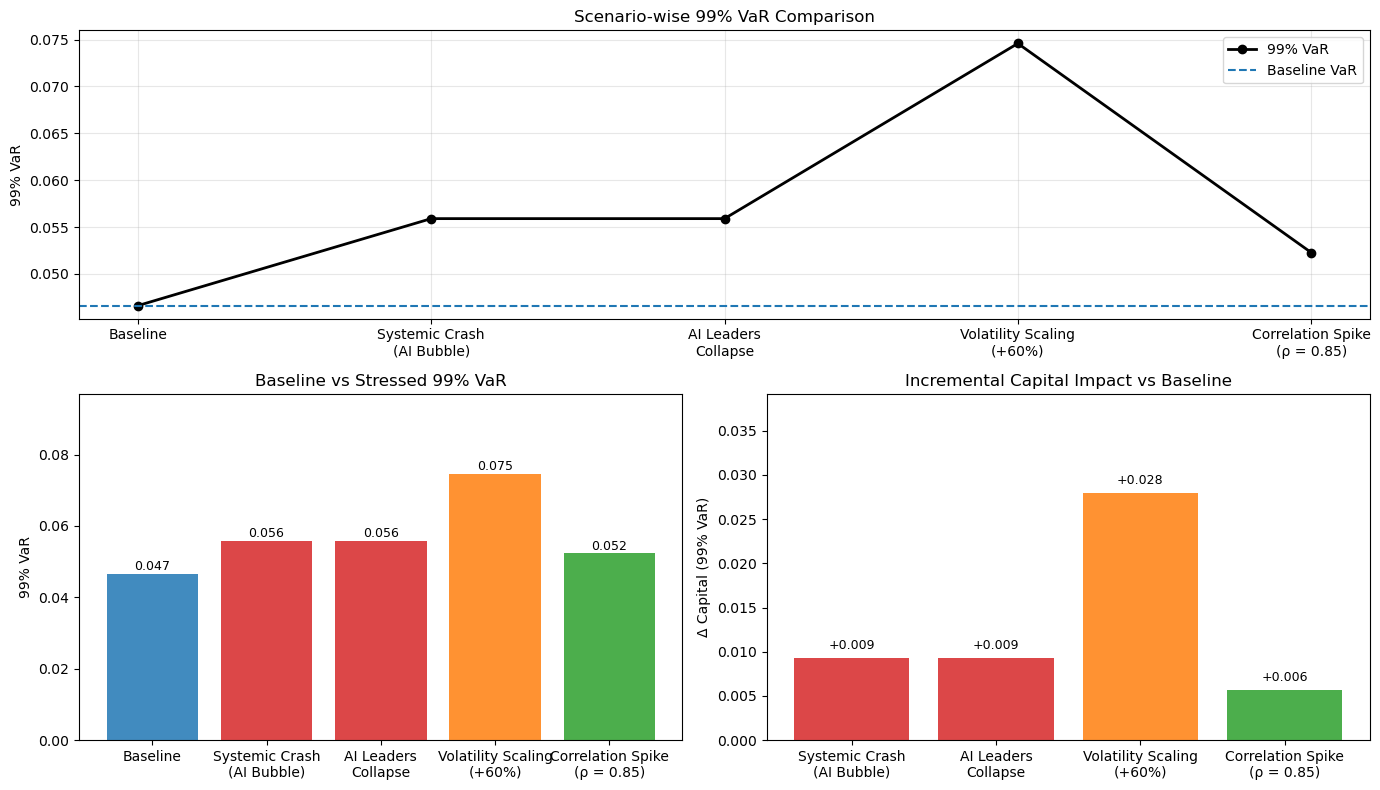

In [29]:



# Data

scenarios = [
    "Baseline",
    "Systemic Crash\n(AI Bubble)",
    "AI Leaders\nCollapse",
    "Volatility Scaling\n(+60%)",
    "Correlation Spike\n(ρ = 0.85)"
]

var_99 = np.array([0.046619, 0.055901, 0.055901, 0.074590, 0.052282])
delta_cap = np.array([0.000000, 0.009282, 0.009282, 0.027971, 0.005663])

baseline_color = "#1f77b4"      # blue
stress_colors = ["#d62728", "#d62728", "#ff7f0e", "#2ca02c"]
colors = [baseline_color] + stress_colors

# -------------------------------
# Dashboard Layout
# -------------------------------
fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])


# Panel 1: Scenario Line Comparison

ax1 = fig.add_subplot(gs[0, :])

ax1.plot(
    scenarios,
    var_99,
    marker='o',
    linewidth=2,
    color='black',
    label="99% VaR"
)

ax1.axhline(
    var_99[0],
    linestyle='--',
    color=baseline_color,
    label="Baseline VaR"
)

ax1.set_title("Scenario-wise 99% VaR Comparison")
ax1.set_ylabel("99% VaR")
ax1.legend()
ax1.grid(alpha=0.3)


# Panel 2: Bar Chart – Baseline vs Stressed VaR

ax2 = fig.add_subplot(gs[1, 0])

bars = ax2.bar(scenarios, var_99, color=colors, alpha=0.85)

ax2.set_title("Baseline vs Stressed 99% VaR")
ax2.set_ylabel("99% VaR")
ax2.set_ylim(0, max(var_99) * 1.3)

for bar in bars:
    h = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width()/2,
        h + 0.001,
        f"{h:.3f}",
        ha="center",
        fontsize=9
    )


# Panel 3: Incremental Capital Impact

ax3 = fig.add_subplot(gs[1, 1])

ax3.bar(
    scenarios[1:], 
    delta_cap[1:], 
    color=stress_colors,
    alpha=0.85
)

ax3.set_title("Incremental Capital Impact vs Baseline")
ax3.set_ylabel("Δ Capital (99% VaR)")
ax3.set_ylim(0, max(delta_cap) * 1.4)

for i, d in enumerate(delta_cap[1:]):
    ax3.text(i, d + 0.001, f"+{d:.3f}", ha='center', fontsize=9)

# -------------------------------
plt.tight_layout()
plt.show()
